# Attrition Project DT Classification

### KDD Process
1. Libraries and Attrition Dataset load
1. Data Cleaning: handle missing values, outliers and dimensionality reduction
1. Classification Preprocessing: feature reshaping and training/test partitioning
1. Parameter Tuning
1. Perform Classification
1. Analyze the classification results
1. Analyze the classification performance
1. Can we improve the performance using another classifier?



### Libraries & Attrition dataset load

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import mean
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [117]:
#conda install graphviz

In [118]:
df_train = pd.read_csv("./Dataset/Train_HR_Employee_Attrition.csv")
df_test = pd.read_csv("./Dataset/Test_HR_Employee_Attrition.csv")

### Data Cleaning: missing values, outliers and dimensionality reduction
This section has been replied from data understanding section for both training/test set.  

In [119]:
#SETTING TRAINING SET (as executed in DataUnderstanding-attrition)


#MISSING VALUES

#infer Gender by Gender mode
df_train['Gender']=df_train['Gender'].fillna(df_train['Gender'].mode()[0])

#infer BusinessTravel by BusinessTravel mode
df_train['BusinessTravel']=df_train['BusinessTravel'].fillna(df_train['BusinessTravel'].mode()[0])

#infer PerformanceRating by PerformanceRating mode
df_train['PerformanceRating'] = df_train['PerformanceRating'].fillna(df_train['PerformanceRating'].mode()[0])

#infer YearsAtCompany by YearsAtCompany mean
df_train['YearsAtCompany'] = df_train['YearsAtCompany'].fillna(df_train['YearsAtCompany'].median())

#infer MonthlyIncome by mean grouped by YearsAtCompany-Quartiles
bins = pd.qcut(df_train['YearsAtCompany'],[0,0.25,0.50,0.75,1.0])
df_train['MonthlyIncome'] = df_train['MonthlyIncome'].groupby(bins).apply(
                      lambda x: x.fillna(x.mean()))

#infer Age by mean grouped by MonthlyIncome-quartiles
bins = pd.qcut(df_train['MonthlyIncome'],[0,0.25,0.50,0.75,1.0])
df_train['Age'] = df_train['Age'].groupby(bins).apply(lambda x: x.fillna(x.mean()))

#TrainingTimesLastYear by fillna with TrainingTimesLastYear values probability
df_train['TrainingTimesLastYear'] = df_train['TrainingTimesLastYear'].fillna(df_train['TrainingTimesLastYear'].mode()[0])


#OUTLIERS
df_train["MonthlyIncomeTrans"] = np.log(df_train['MonthlyIncome'])


#DIENSIONALITY REDUCTION
df_train['YearsMean'] = None
for index, row in df_train.iterrows(): 
    df_train.loc[index, 'YearsMean'] = mean((row['YearsInCurrentRole'], row['YearsSinceLastPromotion'], row['YearsWithCurrManager']))

df_train = df_train.drop(columns = ['MonthlyIncome','YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager','Over18','StandardHours'], axis = 'columns')

In [120]:
#SETTING TEST SET (how we did before for traing set )


#MISSING VALUES

#infer Gender by Gender mode
df_test['Gender']=df_test['Gender'].fillna(df_test['Gender'].mode()[0])

#infer BusinessTravel by BusinessTravel mode
df_test['BusinessTravel']=df_test['BusinessTravel'].fillna(df_test['BusinessTravel'].mode()[0])

#infer PerformanceRating by PerformanceRating mode
df_test['PerformanceRating'] = df_test['PerformanceRating'].fillna(df_test['PerformanceRating'].mode()[0])

#infer YearsAtCompany by YearsAtCompany mean
df_test['YearsAtCompany'] = df_test['YearsAtCompany'].fillna(df_test['YearsAtCompany'].median())

#infer MonthlyIncome by mean grouped by YearsAtCompany-Quartiles
bins = pd.qcut(df_test['YearsAtCompany'],[0,0.25,0.50,0.75,1.0])
df_test['MonthlyIncome'] = df_test['MonthlyIncome'].groupby(bins).apply(
                      lambda x: x.fillna(x.mean()))

#infer Age by mean grouped by MonthlyIncome-quartiles
bins = pd.qcut(df_test['MonthlyIncome'],[0,0.25,0.50,0.75,1.0])
df_test['Age'] = df_test['Age'].groupby(bins).apply(lambda x: x.fillna(x.mean()))

#TrainingTimesLastYear by fillna with TrainingTimesLastYear values probability
df_test['TrainingTimesLastYear'] = df_test['TrainingTimesLastYear'].fillna(df_test['TrainingTimesLastYear'].mode()[0])


#OUTLIERS
df_test["MonthlyIncomeTrans"] = np.log(df_test['MonthlyIncome'])


#DIENSIONALITY REDUCTION
df_test['YearsMean'] = None
for index, row in df_test.iterrows(): 
    df_test.loc[index, 'YearsMean'] = mean((row['YearsInCurrentRole'], row['YearsSinceLastPromotion'], row['YearsWithCurrManager']))

df_test = df_test.drop(columns = ['MonthlyIncome','YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager','Over18','StandardHours'], axis = 'columns')

In [121]:
df_train['Attrition'].value_counts()

No     984
Yes    192
Name: Attrition, dtype: int64

In [122]:
df_test['Attrition'].value_counts()

No     249
Yes     45
Name: Attrition, dtype: int64

### Classification Preprocessing
Nominal features have been reshaped for both sets 

In [123]:
from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['Attrition', 'BusinessTravel','Department','EducationField', 'Gender', 'JobRole', 
                 'MaritalStatus', 'OverTime', 'YearsMean']

for col in column2encode:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    label_encoders[col] = le
    
for col in column2encode:
    le = LabelEncoder()
    df_test[col] = le.fit_transform(df_test[col])
    label_encoders[col] = le


Partitioning training and test set.

In [124]:
from sklearn.model_selection import train_test_split

attributes = [col for col in df_train.columns if col != 'Attrition']

# Full dataset
df = df_train.append(df_test)
X = df[attributes].values
y = df['Attrition']

# Training split
X_train = df_train[attributes].values
y_train = df_train['Attrition']

# Test split
X_test = df_test[attributes].values
y_test = df_test['Attrition']

X.shape, X_train.shape, X_test.shape,y.shape, y_train.shape, y_test.shape

((1470, 28), (1176, 28), (294, 28), (1470,), (1176,), (294,))

### Simple decision tree: 5-fold cross validation

In [125]:
# Simple decision tree by 10 cross validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score,recall_score,precision_score, f1_score, classification_report

clf = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_split=2, min_samples_leaf=1)

scores = cross_val_score(clf, X_train, y_train, cv=4)
print('5-fold Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='recall_weighted')
print('5-fold recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='precision_weighted')
print('5-fold precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='f1_weighted')
print('5-fold F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

print()
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train recall %s' % recall_score(y_train, y_pred_tr,average=None))
print('Train precision %s' % precision_score(y_train, y_pred_tr,average=None))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr,average=None))
print()
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test recall %s' % recall_score(y_test, y_pred,average=None))
print('Test precision %s' % precision_score(y_test, y_pred,average=None))
print('Test F1-score %s' % f1_score(y_test, y_pred,average=None))
print()
print(confusion_matrix(y_train, y_pred_tr))
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))


5-fold Accuracy: 0.8512 (+/- 0.03)
5-fold recall: 0.8512 (+/- 0.03)
5-fold precision: 0.8343 (+/- 0.03)
5-fold F1-score: 0.8265 (+/- 0.06)

Train Accuracy 0.8494897959183674
Train recall [0.94512195 0.359375  ]
Train precision [0.88319088 0.56097561]
Train F1-score [0.91310751 0.43809524]

Test Accuracy 0.8231292517006803
Test recall [0.91967871 0.28888889]
Test precision [0.87739464 0.39393939]
Test F1-score [0.89803922 0.33333333]

[[930  54]
 [123  69]]

[[229  20]
 [ 32  13]]

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       249
           1       0.39      0.29      0.33        45

    accuracy                           0.82       294
   macro avg       0.64      0.60      0.62       294
weighted avg       0.80      0.82      0.81       294



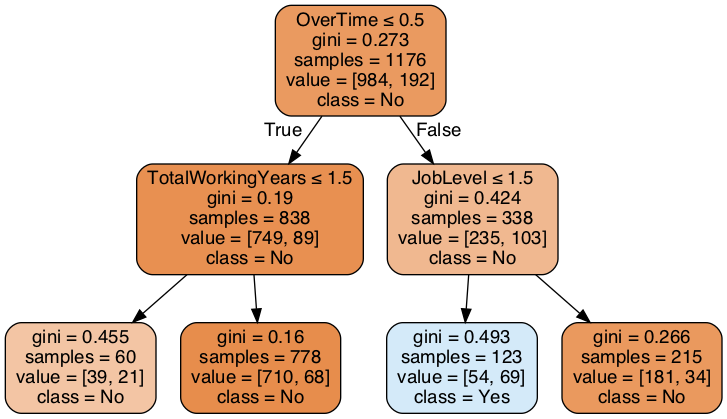

In [126]:
import pydotplus
from sklearn import tree
from IPython.display import Image

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=attributes,
                                class_names=['Yes' if x == 1 else 'No' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=6)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [127]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc_sdt = roc_auc_score(y_test, y_pred)

0.6042838018741632


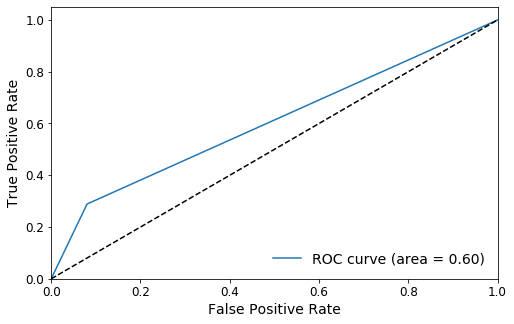

In [128]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_sdt))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14) 
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

### Parameter Tuning - RandomizedSearchCV

In [129]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [130]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [131]:
grid_param_list = {'max_depth': list(np.arange(2, 10)),
              'min_samples_split': [2, 5, 10, 20, 30,40,50,100],
              'min_samples_leaf': [1, 5, 10, 20, 30,40, 50,100],
             }

grid_search = GridSearchCV(clf, param_grid=grid_param_list)
grid_search.fit(X, y)
clf = grid_search.best_estimator_
report(grid_search.cv_results_, n_top=25)

Model with rank: 1
Mean validation score: 0.848 (std: 0.008)
Parameters: {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.848 (std: 0.008)
Parameters: {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.848 (std: 0.008)
Parameters: {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.848 (std: 0.008)
Parameters: {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 20}

Model with rank: 1
Mean validation score: 0.848 (std: 0.008)
Parameters: {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 30}

Model with rank: 1
Mean validation score: 0.848 (std: 0.008)
Parameters: {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 40}

Model with rank: 1
Mean validation score: 0.848 (std: 0.008)
Parameters: {'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 2}

Model with rank: 1
Mean

In [132]:


l = [ (5,20,2), (5,20,5), (5,20,10), (5,20,20), (5,20,30), (5,20,40),
      (6,20,2), (6,20,5), (6,20,10), (6,20,20), (6,20,30), (6,20,40),
      (7,20,2), (7,20,5), (7,20,10), (7,20,20), (7,20,30), (7,20,40),
      (8,20,2), (8,20,5), (8,20,10), (8,20,20), (8,20,30), (8,20,40),
      (9,20,2), (9,20,5), (9,20,10), (9,20,20), (9,20,30), (9,20,40)]

for x in l:

    clf = DecisionTreeClassifier(criterion='gini', max_depth=x[0], min_samples_split=x[2], min_samples_leaf=x[1])
    
    print(f"max_depth: {x[0]} min_samples_leaf: {x[1]} min_samples_split: {x[2]}")
    scores = cross_val_score(clf, X_train, y_train, cv=4)
    print('5-fold Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='recall_weighted')
    print('5-fold recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='precision_weighted')
    print('5-fold precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='f1_weighted')
    print('5-fold F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_tr = clf.predict(X_train)

    print()
    print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
    print('Train recall %s' % recall_score(y_train, y_pred_tr,average=None))
    print('Train precision %s' % precision_score(y_train, y_pred_tr,average=None))
    print('Train F1-score %s' % f1_score(y_train, y_pred_tr,average=None))
    print()
    print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
    print('Test recall %s' % recall_score(y_test, y_pred,average=None))
    print('Test precision %s' % precision_score(y_test, y_pred,average=None))
    print('Test F1-score %s' % f1_score(y_test, y_pred,average=None))
    
    #print()
    #print(confusion_matrix(y_train, y_pred_tr))
    #print()
    #print(confusion_matrix(y_test, y_pred))

max_depth: 5 min_samples_leaf: 20 min_samples_split: 2
5-fold Accuracy: 0.8401 (+/- 0.00)
5-fold recall: 0.8401 (+/- 0.00)
5-fold precision: 0.8186 (+/- 0.03)
5-fold F1-score: 0.8215 (+/- 0.03)

Train Accuracy 0.8707482993197279
Train recall [0.96443089 0.390625  ]
Train precision [0.8902439  0.68181818]
Train F1-score [0.92585366 0.49668874]

Test Accuracy 0.8503401360544217
Test recall [0.93975904 0.35555556]
Test precision [0.88973384 0.51612903]
Test F1-score [0.9140625  0.42105263]
max_depth: 5 min_samples_leaf: 20 min_samples_split: 5
5-fold Accuracy: 0.8401 (+/- 0.00)
5-fold recall: 0.8401 (+/- 0.00)
5-fold precision: 0.8186 (+/- 0.03)
5-fold F1-score: 0.8215 (+/- 0.03)

Train Accuracy 0.8707482993197279
Train recall [0.96443089 0.390625  ]
Train precision [0.8902439  0.68181818]
Train F1-score [0.92585366 0.49668874]

Test Accuracy 0.8503401360544217
Test recall [0.93975904 0.35555556]
Test precision [0.88973384 0.51612903]
Test F1-score [0.9140625  0.42105263]
max_depth: 5 min

5-fold recall: 0.8401 (+/- 0.00)
5-fold precision: 0.8186 (+/- 0.03)
5-fold F1-score: 0.8215 (+/- 0.03)

Train Accuracy 0.8707482993197279
Train recall [0.96443089 0.390625  ]
Train precision [0.8902439  0.68181818]
Train F1-score [0.92585366 0.49668874]

Test Accuracy 0.8503401360544217
Test recall [0.93975904 0.35555556]
Test precision [0.88973384 0.51612903]
Test F1-score [0.9140625  0.42105263]
max_depth: 8 min_samples_leaf: 20 min_samples_split: 5
5-fold Accuracy: 0.8401 (+/- 0.00)
5-fold recall: 0.8401 (+/- 0.00)
5-fold precision: 0.8186 (+/- 0.03)
5-fold F1-score: 0.8215 (+/- 0.03)

Train Accuracy 0.8707482993197279
Train recall [0.96443089 0.390625  ]
Train precision [0.8902439  0.68181818]
Train F1-score [0.92585366 0.49668874]

Test Accuracy 0.8503401360544217
Test recall [0.93975904 0.35555556]
Test precision [0.88973384 0.51612903]
Test F1-score [0.9140625  0.42105263]
max_depth: 8 min_samples_leaf: 20 min_samples_split: 10
5-fold Accuracy: 0.8401 (+/- 0.00)
5-fold recall: 

In [133]:
randomized_param_list = {'max_depth': [None] + list(np.arange(2, 100)),
              'min_samples_split': [2, 5, 10, 20, 30,40,50,100,150,200],
              'min_samples_leaf': [1, 5, 10, 20, 30,40, 50,100,150,200],
             }


clf = DecisionTreeClassifier(criterion='gini',max_depth=2, min_samples_split=2,min_samples_leaf=1)
random_search = RandomizedSearchCV(clf, param_distributions=randomized_param_list, n_iter=100)
random_search.fit(X_train, y_train)
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.850 (std: 0.020)
Parameters: {'min_samples_split': 200, 'min_samples_leaf': 30, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.848 (std: 0.022)
Parameters: {'min_samples_split': 50, 'min_samples_leaf': 50, 'max_depth': 79}

Model with rank: 2
Mean validation score: 0.848 (std: 0.022)
Parameters: {'min_samples_split': 30, 'min_samples_leaf': 50, 'max_depth': 26}

Model with rank: 2
Mean validation score: 0.848 (std: 0.022)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 50, 'max_depth': 96}

Model with rank: 2
Mean validation score: 0.848 (std: 0.022)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 40, 'max_depth': 95}

Model with rank: 2
Mean validation score: 0.848 (std: 0.022)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 40, 'max_depth': 71}

Model with rank: 2
Mean validation score: 0.848 (std: 0.022)
Parameters: {'min_samples_split': 50, 'min_samples_leaf': 50, 'max_depth': 73}

Model with

In [134]:


l = [ (2,5,150), (2,40,10), (11,50,30), (14,50,50), (15,50,50), (39,50,20)]

for x in l:

    clf = DecisionTreeClassifier(criterion='gini', max_depth=x[0], min_samples_split=x[2], min_samples_leaf=x[1])
    
    print(f"max_depth: {x[0]} min_samples_leaf: {x[1]} min_samples_split: {x[2]}")
    scores = cross_val_score(clf, X_train, y_train, cv=4)
    print('5-fold Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='recall_weighted')
    print('5-fold recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='precision_weighted')
    print('5-fold precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='f1_weighted')
    print('5-fold F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_tr = clf.predict(X_train)

    print()
    print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
    print('Train recall %s' % recall_score(y_train, y_pred_tr,average=None))
    print('Train precision %s' % precision_score(y_train, y_pred_tr,average=None))
    print('Train F1-score %s' % f1_score(y_train, y_pred_tr,average=None))
    print()
    print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
    print('Test recall %s' % recall_score(y_test, y_pred,average=None))
    print('Test precision %s' % precision_score(y_test, y_pred,average=None))
    print('Test F1-score %s' % f1_score(y_test, y_pred,average=None))
    
    #print()
    #print(confusion_matrix(y_train, y_pred_tr))
    #print()
    #print(confusion_matrix(y_test, y_pred))

max_depth: 2 min_samples_leaf: 5 min_samples_split: 150
5-fold Accuracy: 0.8495 (+/- 0.03)
5-fold recall: 0.8495 (+/- 0.03)
5-fold precision: 0.8020 (+/- 0.12)
5-fold F1-score: 0.8212 (+/- 0.07)

Train Accuracy 0.8494897959183674
Train recall [0.94512195 0.359375  ]
Train precision [0.88319088 0.56097561]
Train F1-score [0.91310751 0.43809524]

Test Accuracy 0.8231292517006803
Test recall [0.91967871 0.28888889]
Test precision [0.87739464 0.39393939]
Test F1-score [0.89803922 0.33333333]
max_depth: 2 min_samples_leaf: 40 min_samples_split: 10
5-fold Accuracy: 0.8495 (+/- 0.03)
5-fold recall: 0.8495 (+/- 0.03)
5-fold precision: 0.8020 (+/- 0.12)
5-fold F1-score: 0.8212 (+/- 0.07)

Train Accuracy 0.8494897959183674
Train recall [0.94512195 0.359375  ]
Train precision [0.88319088 0.56097561]
Train F1-score [0.91310751 0.43809524]

Test Accuracy 0.8231292517006803
Test recall [0.91967871 0.28888889]
Test precision [0.87739464 0.39393939]
Test F1-score [0.89803922 0.33333333]
max_depth: 11 

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5-fold Accuracy: 0.8469 (+/- 0.03)
5-fold recall: 0.8469 (+/- 0.03)
5-fold precision: 0.8246 (+/- 0.05)
5-fold F1-score: 0.8306 (+/- 0.05)

Train Accuracy 0.8545918367346939
Train recall [0.9847561 0.1875   ]
Train precision [0.86133333 0.70588235]
Train F1-score [0.91891892 0.2962963 ]

Test Accuracy 0.8401360544217688
Test recall [0.96385542 0.15555556]
Test precision [0.86330935 0.4375    ]
Test F1-score [0.91081594 0.2295082 ]
max_depth: 15 min_samples_leaf: 50 min_samples_split: 50
5-fold Accuracy: 0.8469 (+/- 0.03)
5-fold recall: 0.8469 (+/- 0.03)
5-fold precision: 0.8246 (+/- 0.05)
5-fold F1-score: 0.8306 (+/- 0.05)

Train Accuracy 0.8545918367346939
Train recall [0.9847561 0.1875   ]
Train precision [0.86133333 0.70588235]
Train F1-score [0.91891892 0.2962963 ]

Test Accuracy 0.8401360544217688
Test recall [0.96385542 0.15555556]
Test precision [0.86330935 0.4375    ]
Test F1-score [0.91081594 0.2295082 ]
max_depth: 39 min_samples_leaf: 50 min_samples_split: 20
5-fold Accuracy:

### Perform Classification

In [135]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2, min_samples_leaf=20)
clf = clf.fit(X_train, y_train)

In [136]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

### Analyze the classification results

Features importances

In [137]:
for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

Age 0.0
BusinessTravel 0.0
DailyRate 0.050170560582563715
Department 0.0
DistanceFromHome 0.06528151680735407
Education 0.0
EducationField 0.0
EnvironmentSatisfaction 0.007317908256775179
Gender 0.0
HourlyRate 0.051914779640197244
JobInvolvement 0.0
JobLevel 0.26365413604398524
JobRole 0.05685287622278899
JobSatisfaction 0.0207459838322203
MaritalStatus 0.0
MonthlyRate 0.0
NumCompaniesWorked 0.0631994210413912
OverTime 0.19712877640908216
PercentSalaryHike 0.0
PerformanceRating 0.0
RelationshipSatisfaction 0.005763825944333534
StockOptionLevel 0.045478866398556625
TotalWorkingYears 0.07976555187211214
TrainingTimesLastYear 0.0
WorkLifeBalance 0.043658960924841506
YearsAtCompany 0.0
MonthlyIncomeTrans 0.021656982001761426
YearsMean 0.02740985402203683


Visualize the decision tree

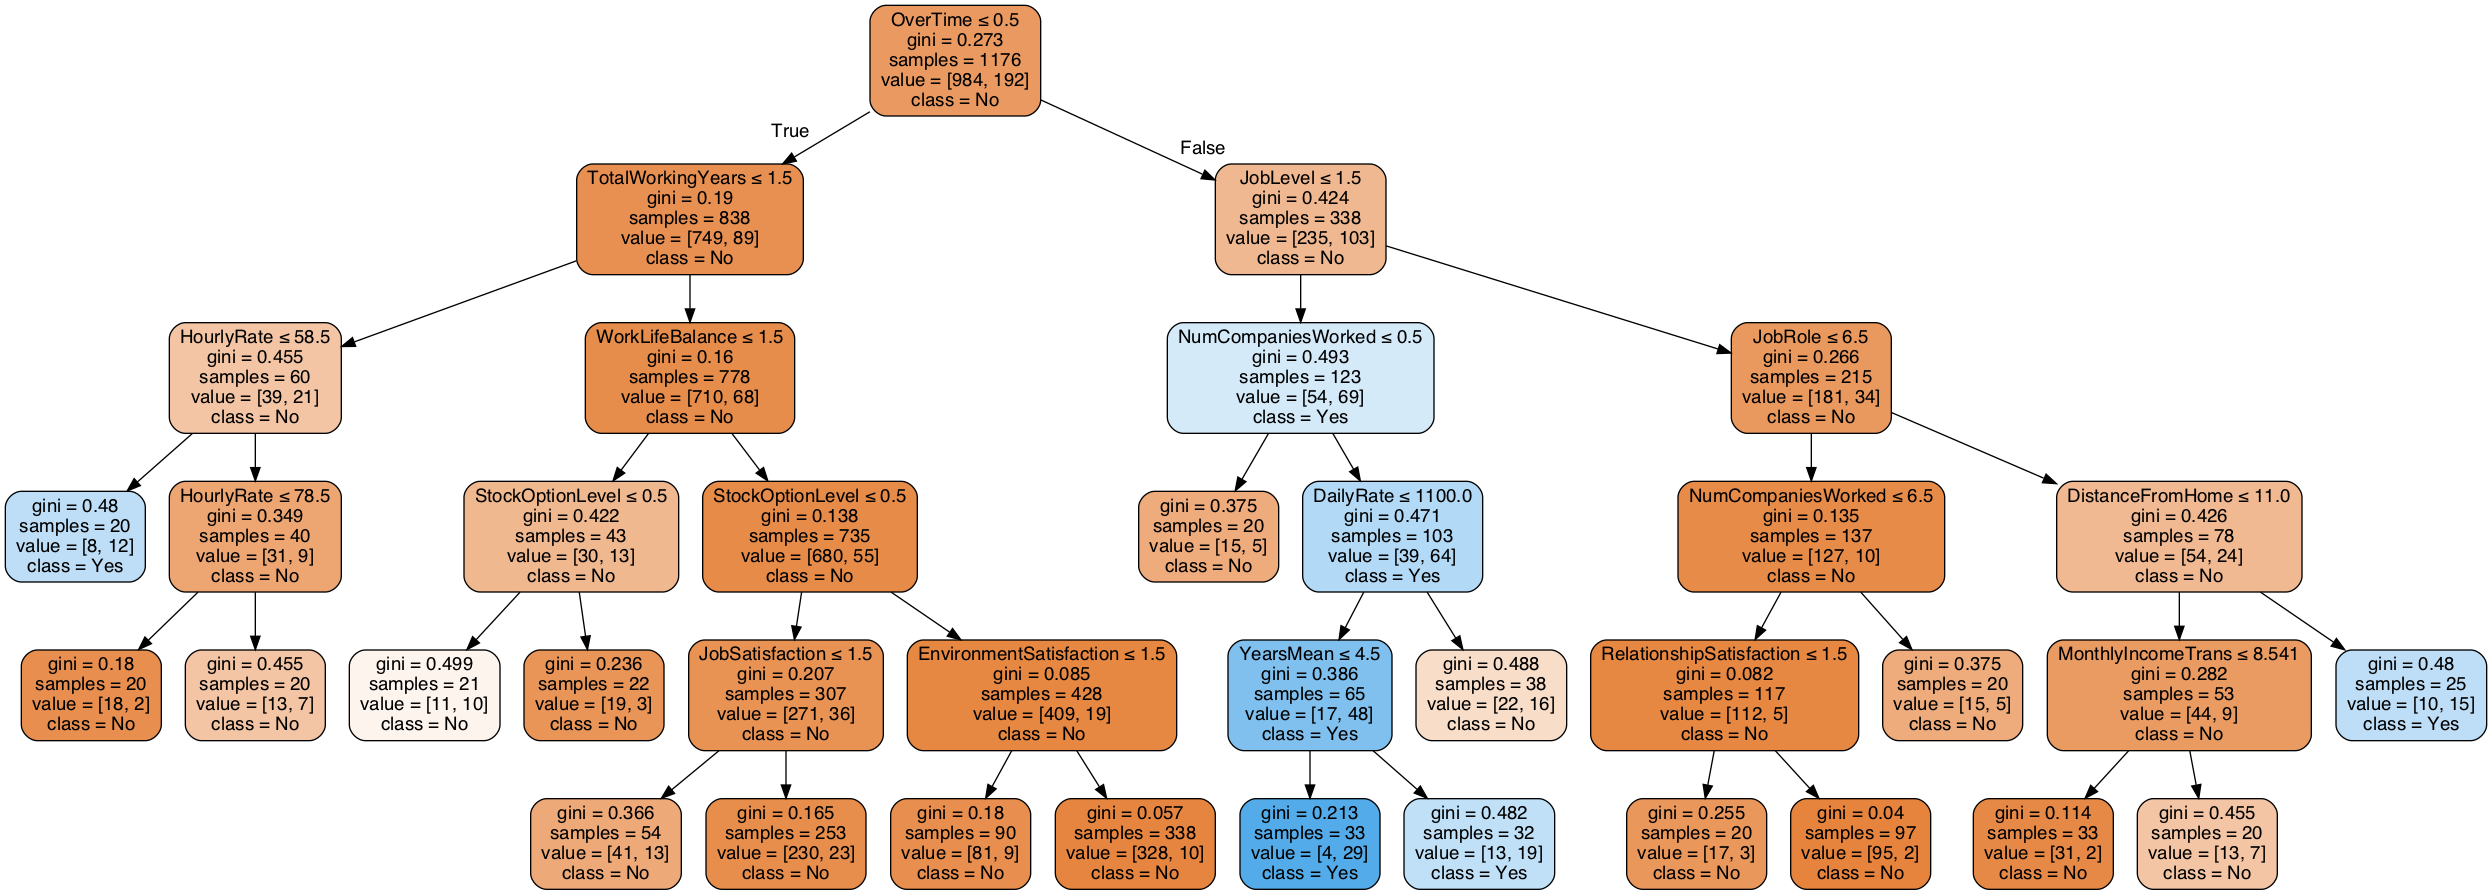

In [138]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=attributes,
                                class_names=['Yes' if x == 1 else 'No' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=6)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())



### Analyze the classification performance

In [139]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

Assess the performances

In [140]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train recall %s' % recall_score(y_train, y_pred_tr,average=None))
print('Train precision %s' % precision_score(y_train, y_pred_tr,average=None))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr,average=None))
print()
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test recall %s' % recall_score(y_test, y_pred,average=None))
print('Test precision %s' % precision_score(y_test, y_pred,average=None))
print('Test F1-score %s' % f1_score(y_test, y_pred,average=None))

#print(classification_report(y_test, y_pred))
print(confusion_matrix(y_train, y_pred_tr))
print(confusion_matrix(y_test, y_pred))

Train Accuracy 0.8707482993197279
Train recall [0.96443089 0.390625  ]
Train precision [0.8902439  0.68181818]
Train F1-score [0.92585366 0.49668874]

Test Accuracy 0.8503401360544217
Test recall [0.93975904 0.35555556]
Test precision [0.88973384 0.51612903]
Test F1-score [0.9140625  0.42105263]
[[949  35]
 [117  75]]
[[234  15]
 [ 29  16]]


In [141]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc_odt = roc_auc_score(y_test, y_pred)

0.647657295850067


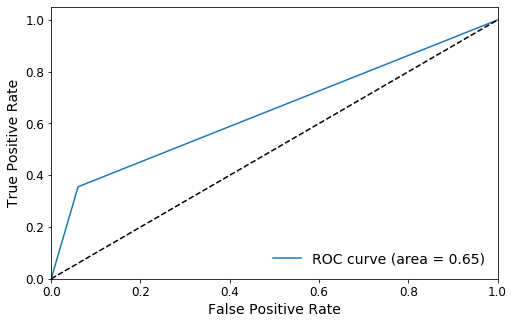

In [142]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_odt))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14) 
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

### Can we improve the performance using another classifier?

In [143]:
from sklearn.ensemble import RandomForestClassifier

In [144]:
param_list = {'max_depth': [None] + list(np.arange(2, 100)),
              'min_samples_split': [2, 5, 10, 15, 20, 30,40, 50, 100, 150],
              'min_samples_leaf': [1, 5, 10, 15, 20, 30, 50, 100, 150],
              'criterion': ['gini', 'entropy'],
             }

clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, 
                             min_samples_split=2, min_samples_leaf=1, class_weight=None)

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=200)
random_search.fit(X_train, y_train)
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.855 (std: 0.009)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 80, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.854 (std: 0.011)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 98, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.853 (std: 0.006)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'entropy'}



In [145]:
clf = random_search.best_estimator_
print(clf)

scores = cross_val_score(clf, X_train, y_train, cv=4)
print('5-fold Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='recall_weighted')
print('5-fold recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='precision_weighted')
print('5-fold precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='f1_weighted')
print('5-fold F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

print()
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train recall %s' % recall_score(y_train, y_pred_tr,average=None))
print('Train precision %s' % precision_score(y_train, y_pred_tr,average=None))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr,average=None))
print()
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test recall %s' % recall_score(y_test, y_pred,average=None))
print('Test precision %s' % precision_score(y_test, y_pred,average=None))
print('Test F1-score %s' % f1_score(y_test, y_pred,average=None))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_train, y_pred_tr))
print(confusion_matrix(y_test, y_pred))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=80, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
5-fold Accuracy: 0.8529 (+/- 0.01)
5-fold recall: 0.8537 (+/- 0.01)
5-fold precision: 0.8501 (+/- 0.04)
5-fold F1-score: 0.8063 (+/- 0.03)

Train Accuracy 0.9940476190476191
Train recall [1.         0.96354167]
Train precision [0.99293643 1.        ]
Train F1-score [0.9964557  0.98143236]

Test Accuracy 0.8503401360544217
Test recall [0.98393574 0.11111111]
Test precision [0.85964912 0.55555556]
Test F1-score [0.917603   0.18518519]
              p

In [146]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc_rf = roc_auc_score(y_test, y_pred, average=None)
roc_auc_rf

0.5475234270414994


0.5475234270414994

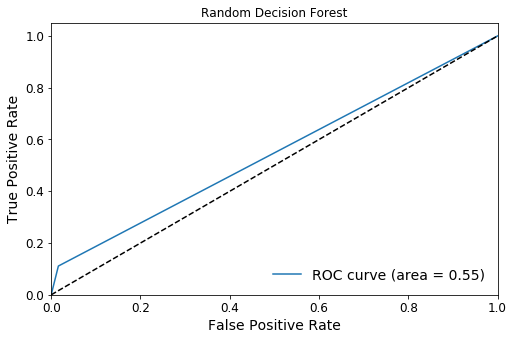

In [147]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_rf))

plt.title("Random Decision Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14) 
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [148]:
from sklearn.neighbors import KNeighborsClassifier

In [149]:
for i in np.arange(1,15):
    print(f"KNN: k={i}")
    clf = KNeighborsClassifier(n_neighbors=i)

    scores = cross_val_score(clf, X_train, y_train, cv=4)
    print('5-fold Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='recall_weighted')
    print('5-fold recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='precision_weighted')
    print('5-fold precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='f1_weighted')
    print('5-fold F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
    
    clf = KNeighborsClassifier(n_neighbors=i)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_tr = clf.predict(X_train)

    print()
    print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
    print('Train recall %s' % recall_score(y_train, y_pred_tr,average=None))
    print('Train precision %s' % precision_score(y_train, y_pred_tr,average=None))
    print('Train F1-score %s' % f1_score(y_train, y_pred_tr,average=None))
    print()
    print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
    print('Test recall %s' % recall_score(y_test, y_pred,average=None))
    print('Test precision %s' % precision_score(y_test, y_pred,average=None))
    print('Test F1-score %s' % f1_score(y_test, y_pred,average=None))
    print()
    print(confusion_matrix(y_train, y_pred_tr))
    print()
    print(confusion_matrix(y_test, y_pred))
    print()

KNN: k=1
5-fold Accuracy: 0.7355 (+/- 0.05)
5-fold recall: 0.7355 (+/- 0.05)
5-fold precision: 0.7407 (+/- 0.04)
5-fold F1-score: 0.7378 (+/- 0.04)

Train Accuracy 1.0
Train recall [1. 1.]
Train precision [1. 1.]
Train F1-score [1. 1.]

Test Accuracy 0.7619047619047619
Test recall [0.86345382 0.2       ]
Test precision [0.85657371 0.20930233]
Test F1-score [0.86       0.20454545]

[[984   0]
 [  0 192]]

[[215  34]
 [ 36   9]]

KNN: k=2
5-fold Accuracy: 0.8189 (+/- 0.02)
5-fold recall: 0.8189 (+/- 0.02)
5-fold precision: 0.7404 (+/- 0.06)
5-fold F1-score: 0.7629 (+/- 0.02)

Train Accuracy 0.8724489795918368
Train recall [1.      0.21875]
Train precision [0.86772487 1.        ]
Train F1-score [0.92917847 0.35897436]

Test Accuracy 0.8299319727891157
Test recall [0.96787149 0.06666667]
Test precision [0.85159011 0.27272727]
Test F1-score [0.90601504 0.10714286]

[[984   0]
 [150  42]]

[[241   8]
 [ 42   3]]

KNN: k=3
5-fold Accuracy: 0.7951 (+/- 0.04)
5-fold recall: 0.7951 (+/- 0.04)
5-

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train Accuracy 0.8392857142857143
Train recall [0.9949187  0.04166667]
Train precision [0.84178848 0.61538462]
Train F1-score [0.91197019 0.07804878]

Test Accuracy 0.8469387755102041
Test recall [0.99196787 0.04444444]
Test precision [0.85172414 0.5       ]
Test F1-score [0.91651206 0.08163265]

[[979   5]
 [184   8]]

[[247   2]
 [ 43   2]]

KNN: k=7
5-fold Accuracy: 0.8299 (+/- 0.02)
5-fold recall: 0.8299 (+/- 0.02)
5-fold precision: 0.7814 (+/- 0.11)
5-fold F1-score: 0.7675 (+/- 0.01)

Train Accuracy 0.8460884353741497
Train recall [0.99390244 0.08854167]
Train precision [0.84822203 0.73913043]
Train F1-score [0.91530182 0.15813953]

Test Accuracy 0.8367346938775511
Test recall [0.97991968 0.04444444]
Test precision [0.85017422 0.28571429]
Test F1-score [0.91044776 0.07692308]

[[978   6]
 [175  17]]

[[244   5]
 [ 43   2]]

KNN: k=8
5-fold Accuracy: 0.8333 (+/- 0.01)
5-fold recall: 0.8333 (+/- 0.01)
5-fold precision: 0.6997 (+/- 0.00)
5-fold F1-score: 0.7607 (+/- 0.00)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train Accuracy 0.8375850340136054
Train recall [0.99796748 0.015625  ]
Train precision [0.83859949 0.6       ]
Train F1-score [0.91136891 0.03045685]

Test Accuracy 0.8469387755102041
Test recall [0.99598394 0.02222222]
Test precision [0.84931507 0.5       ]
Test F1-score [0.9168207  0.04255319]

[[982   2]
 [189   3]]

[[248   1]
 [ 44   1]]

KNN: k=9
5-fold Accuracy: 0.8316 (+/- 0.01)
5-fold recall: 0.8316 (+/- 0.01)
5-fold precision: 0.7514 (+/- 0.14)
5-fold F1-score: 0.7629 (+/- 0.01)

Train Accuracy 0.8392857142857143
Train recall [0.99593496 0.03645833]
Train precision [0.84120172 0.63636364]
Train F1-score [0.91205212 0.06896552]

Test Accuracy 0.8435374149659864
Test recall [0.99196787 0.02222222]
Test precision [0.84879725 0.33333333]
Test F1-score [0.91481481 0.04166667]

[[980   4]
 [185   7]]

[[247   2]
 [ 44   1]]

KNN: k=10
5-fold Accuracy: 0.8350 (+/- 0.01)
5-fold recall: 0.8350 (+/- 0.01)
5-fold precision: 0.6999 (+/- 0.00)
5-fold F1-score: 0.7615 (+/- 0.00)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train Accuracy 0.8392857142857143
Train recall [0.99898374 0.02083333]
Train precision [0.83945346 0.8       ]
Train F1-score [0.91229698 0.04060914]

Test Accuracy 0.8469387755102041
Test recall [0.99598394 0.02222222]
Test precision [0.84931507 0.5       ]
Test F1-score [0.9168207  0.04255319]

[[983   1]
 [188   4]]

[[248   1]
 [ 44   1]]

KNN: k=11
5-fold Accuracy: 0.8350 (+/- 0.01)
5-fold recall: 0.8350 (+/- 0.01)
5-fold precision: 0.6999 (+/- 0.00)
5-fold F1-score: 0.7615 (+/- 0.00)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train Accuracy 0.8367346938775511
Train recall [0.99593496 0.02083333]
Train precision [0.8390411 0.5      ]
Train F1-score [0.91078067 0.04      ]

Test Accuracy 0.8469387755102041
Test recall [0.99598394 0.02222222]
Test precision [0.84931507 0.5       ]
Test F1-score [0.9168207  0.04255319]

[[980   4]
 [188   4]]

[[248   1]
 [ 44   1]]

KNN: k=12
5-fold Accuracy: 0.8359 (+/- 0.00)
5-fold recall: 0.8359 (+/- 0.00)
5-fold precision: 0.7000 (+/- 0.00)
5-fold F1-score: 0.7619 (+/- 0.00)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics


Train Accuracy 0.8367346938775511
Train recall [0.99898374 0.00520833]
Train precision [0.83730835 0.5       ]
Train F1-score [0.91102873 0.01030928]

Test Accuracy 0.8469387755102041
Test recall [1. 0.]
Test precision [0.84693878 0.        ]
Test F1-score [0.91712707 0.        ]

[[983   1]
 [191   1]]

[[249   0]
 [ 45   0]]

KNN: k=13
5-fold Accuracy: 0.8350 (+/- 0.01)
5-fold recall: 0.8350 (+/- 0.01)
5-fold precision: 0.6999 (+/- 0.00)
5-fold F1-score: 0.7615 (+/- 0.00)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics


Train Accuracy 0.8367346938775511
Train recall [0.99796748 0.01041667]
Train precision [0.83788396 0.5       ]
Train F1-score [0.9109462  0.02040816]

Test Accuracy 0.8469387755102041
Test recall [1. 0.]
Test precision [0.84693878 0.        ]
Test F1-score [0.91712707 0.        ]

[[982   2]
 [190   2]]

[[249   0]
 [ 45   0]]

KNN: k=14
5-fold Accuracy: 0.8359 (+/- 0.00)
5-fold recall: 0.8359 (+/- 0.00)
5-fold precision: 0.7000 (+/- 0.00)
5-fold F1-score: 0.7619 (+/- 0.00)

Train Accuracy 0.8367346938775511
Train recall [1. 0.]
Train precision [0.83673469 0.        ]
Train F1-score [0.91111111 0.        ]

Test Accuracy 0.8469387755102041
Test recall [1. 0.]
Test precision [0.84693878 0.        ]
Test F1-score [0.91712707 0.        ]

[[984   0]
 [192   0]]

[[249   0]
 [ 45   0]]



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics

In [150]:
clf = KNeighborsClassifier(n_neighbors=6)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc_knn = roc_auc_score(y_test, y_pred, average=None)
roc_auc_knn

0.5182061579651942


0.5182061579651942

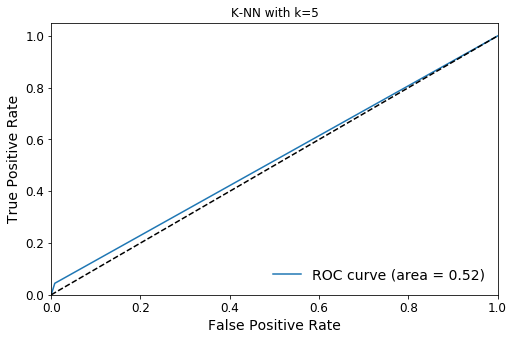

In [151]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_knn))

plt.title("K-NN with k=5")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14) 
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_knn))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18) 
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()